In [1]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
import importlib.util

# Define the path to the .py file
file_path = "/kaggle/input/new-dataloader-prep/dataloader_prep_1.py"

# Load the module
spec = importlib.util.spec_from_file_location("dataloader_prep_1", file_path)
dataloader_prep = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dataloader_prep)

# Now, you can use functions from the script


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Load the dataset
file_path = "/kaggle/input/cyberbullying-tweets-dataset/cyberbullying_tweets.csv"
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [6]:
X = df['tweet_text']
y = df['cyberbullying_type']
print(len(X))

47692


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = seed_value)

# Get unique class counts
class_counts = np.column_stack(np.unique(y_train, return_counts=True))
class_counts

array([['age', 6394],
       ['ethnicity', 6369],
       ['gender', 6378],
       ['not_cyberbullying', 6356],
       ['other_cyberbullying', 6258],
       ['religion', 6398]], dtype=object)

In [8]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
ros = RandomOverSampler()

# Resample the dataset
X_resampled, y_resampled = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))

# Convert resampled data into a DataFrame
train_os = pd.DataFrame({'text_clean': X_resampled.ravel(), 'sentiment': y_resampled.ravel()})

# Extract resampled values
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

# Get unique class counts
class_counts = np.column_stack(np.unique(y_train, return_counts=True))
class_counts


array([['age', 6398],
       ['ethnicity', 6398],
       ['gender', 6398],
       ['not_cyberbullying', 6398],
       ['other_cyberbullying', 6398],
       ['religion', 6398]], dtype=object)

In [9]:
from collections import Counter

def Vocab(column):
    vocab = [] # Initialize an empty list to store words
    
    # Iterate over each text entry in the column
    for text in column:
        for word in text.split():
            vocab.append(word)
        
    counter = Counter(vocab)
    sorted_words = counter.most_common()
            
    vocab_id = []
    for i, tup in enumerate(sorted_words):
        word, freq = tup
        vocab_id.append((word, i))

    return vocab_id

vocab = Vocab(df["tweet_text"])

In [10]:
Word2Vec_train_data = [text.split() for text in X_train]


In [11]:
train_loader, test_loader, train_dataset, test_dataset, num_labels, label_mapping = dataloader_prep.prepare_dataloader("/kaggle/input/cyberbullying-tweets-dataset/cyberbullying_tweets.csv")

Label mapping: {'not_cyberbullying': 0, 'gender': 1, 'religion': 2, 'other_cyberbullying': 3, 'age': 4, 'ethnicity': 5}
Label distribution:
 label
2    7998
4    7992
1    7973
5    7961
0    7945
3    7823
Name: count, dtype: int64
Dataset Loaded
                                           tweet_text cyberbullying_type  label
0  In other words #katandandre, your food was cra...  not_cyberbullying      0
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying      0
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying      0
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying      0
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying      0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
print(label_mapping)
print(num_labels)

{'not_cyberbullying': 0, 'gender': 1, 'religion': 2, 'other_cyberbullying': 3, 'age': 4, 'ethnicity': 5}
6


In [13]:
len(train_dataset.labels)

42922

In [14]:
from torch.utils.data import random_split, DataLoader

print(len(train_dataset))
print(len(test_dataset))
# Define split ratio (e.g., 80% train, 20% validation)
train_ratio = 0.8
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size  # Remaining for validation

# Split dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create new DataLoaders
train_loader = DataLoader(train_subset, batch_size=train_loader.batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=train_loader.batch_size, shuffle=False)

print(type(train_loader.dataset))
print(type(val_loader))
print(f"Original validation subset size: {len(val_subset)}")
print(f"Original train subset size: {len(train_subset)}")

print(len(train_subset))
print(len(val_subset))

42922
4770
<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataloader.DataLoader'>
Original validation subset size: 8585
Original train subset size: 34337
34337
8585


In [15]:
# Attention mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        """
        Initializes the Attention layer.

        Parameters:
        - hidden_dim: Dimension of the hidden state.
        - is_bidirectional: Whether the LSTM is bidirectional.
        """
        super(Attention, self).__init__()
        factor = 2 if is_bidirectional else 1
        self.attn = nn.Linear(hidden_dim * factor, hidden_dim * factor)
        self.v = nn.Linear(hidden_dim * factor, 1, bias=False)

    def forward(self, lstm_output):
        """
        Computes attention scores.

        Parameters:
        - lstm_output: LSTM output of shape (batch_size, seq_len, hidden_dim * num_directions).

        Returns:
        - Context vector of shape (batch_size, hidden_dim * num_directions).
        """
        attn_scores = self.v(torch.tanh(self.attn(lstm_output)))  # (batch_size, seq_len, 1)
        attn_weights = F.softmax(attn_scores, dim=1)  # (batch_size, seq_len, 1)
        context = torch.bmm(attn_weights.transpose(1, 2), lstm_output).squeeze(1)  # (batch_size, hidden_dim * num_directions)
        return context



In [16]:
class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        """
        Initializes the LSTM sentiment classifier.
        """
        super(LSTM_Sentiment_Classifier, self).__init__()
        factor = 2 if is_bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional, dropout=dropout)
        self.attention = Attention(hidden_dim, is_bidirectional)
        self.fc = nn.Linear(hidden_dim * factor, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        """
        Forward pass of the model.

        Parameters:
        - x: Input tensor of shape (batch_size, seq_length)

        Returns:
        - Output probabilities of shape (batch_size, num_classes)
        """
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_length, hidden_dim * num_directions)
        context = self.attention(lstm_out)  # (batch_size, hidden_dim * num_directions)
        output = self.softmax(self.fc(context))  # (batch_size, num_classes)
        return output


In [17]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = num_labels
VOCAB_SIZE = len(vocab)+1

In [18]:
from tqdm import tqdm
import copy

def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, patience=10):
    """
    Trains the model with validation and early stopping.

    Parameters:
    - model: The model to be trained.
    - train_loader: DataLoader for the training set.
    - val_loader: DataLoader for the validation set.
    - criterion: Loss function.
    - optimizer: Optimizer for training.
    - epochs: Number of training epochs.
    - device: Device for training (e.g., "cuda" or "cpu").
    - patience: Early stopping patience (default: 3 epochs).

    Returns:
    - best_model: The model with the lowest validation loss.
    - train_losses: List of average training losses per epoch.
    - val_losses: List of average validation losses per epoch.
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float("inf")
    patience_counter = 0
    best_model = copy.deepcopy(model)  # Save best model

    for epoch in range(epochs):
        # Training Phase
        model.train()
        epoch_loss, correct, total = 0, 0, 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]") as pbar:
            for batch in pbar:
                inputs = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)

                optimizer.zero_grad()
                output = model(inputs)  # Fix: Only passing `inputs`
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                y_pred_train = torch.argmax(output, dim=1)
                correct += torch.sum(y_pred_train == labels).item()
                total += labels.size(0)

                pbar.set_postfix({
                    "Loss": f"{loss.item():.4f}",
                    "Acc": f"{100 * correct / total:.3f}%"
                })

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = 100 * correct / total
        train_accuracies.append(train_acc)

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]") as pbar:
                for batch in pbar:
                    inputs = batch["input_ids"].to(device)
                    labels = batch["labels"].to(device)

                    output = model(inputs)
                    loss = criterion(output, labels)
                    val_loss += loss.item()

                    y_pred_val = torch.argmax(output, dim=1)
                    val_correct += torch.sum(y_pred_val == labels).item()
                    val_total += labels.size(0)

                    pbar.set_postfix({"Loss": f"{loss.item():.4f}","Acc": f"{100 * val_correct / val_total:.3f}%"})

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * val_correct / val_total
        val_accuracies.append(val_acc)

        # Print epoch summary
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.2f}% Validation Loss   = {avg_val_loss:.4f}, Validation Acc   = {val_acc:.2f}%")

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(model)  
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Early stopping patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping...No improvement in Validation Loss!")
            break

    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

In [19]:
from torch.utils.data import Subset
reduced_train_size = int(0.3*len(train_subset))
reduced_val_size = int(0.3*len(val_subset))

train_indices = list(range(len(train_subset)))
val_indices = list(range(len(val_subset)))

reduced_train_indices = train_indices[:reduced_train_size]
reduced_val_indices = val_indices[:reduced_val_size]

reduced_train_dataset = Subset(train_subset, reduced_train_indices)
reduced_val_dataset = Subset(val_subset, reduced_val_indices)

reduced_train_loader = DataLoader(reduced_train_dataset, batch_size = 32, shuffle=True)
reduced_val_loader = DataLoader(reduced_val_dataset, batch_size=32, shuffle = False)

print(len(val_subset))
print(len(reduced_val_dataset))



8585
2575


In [20]:
import optuna
import itertools
from torch.utils.data import DataLoader

tried_configs = set()

# Objective function for tuning
def objective(trial):
    embedding_dim = trial.suggest_categorical("embedding_dim", [200, 300])
    hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256])
    is_bidirectional = trial.suggest_categorical("is_bidirectional", [True, False])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-3)
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.3, 0.5])
    lstm_layers = trial.suggest_categorical("lstm_layers",[2,3])
    
    # Hyperparameter combination
    config = (embedding_dim, hidden_dim, is_bidirectional, lr, dropout_rate, lstm_layers)

    # Check if this combination was already tried
    if config in tried_configs:
        print(f"Skipping already tried configuration: {config}")
        raise optuna.TrialPruned()  # Prune this trial early

    # Add new config to the set
    tried_configs.add(config)
    
    model = LSTM_Sentiment_Classifier(
        vocab_size=VOCAB_SIZE,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        num_classes=NUM_CLASSES,
        lstm_layers=lstm_layers,
        dropout=dropout_rate,
        is_bidirectional=is_bidirectional
    ).to(DEVICE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    print(f"\nTrial {trial.number}: Embedding_Dim: {embedding_dim}, Hidden_Dim: {hidden_dim}, Is Bidirectional: {is_bidirectional}, Learning Rate: {lr}, LSTM Layers: {lstm_layers}, Dropout Rate: {dropout_rate}")

    best_model, train_losses, val_losses, train_accuracies, val_accuracies = train(
        model, reduced_train_loader, reduced_val_loader, criterion, optimizer, epochs=3, device=DEVICE
    )

    best_val_loss = val_losses[0]
    for val_loss in val_losses:
        if val_loss<best_val_loss:
            best_val_loss = val_loss
    return best_val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=70)

print("Best Params:", study.best_params)


[I 2025-03-29 22:50:30,066] A new study created in memory with name: no-name-cf68da35-3dc2-4f69-b3d1-ff550d91a568
<ipython-input-20-db74c927c736>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-3)



Trial 0: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: False, Learning Rate: 0.000792653313412741, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 122.12it/s, Loss=0.3864, Acc=76.350%]


Epoch 1: Train Loss = 0.8608, Train Acc = 62.73% Validation Loss   = 0.5327, Validation Acc   = 76.35%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 125.72it/s, Loss=0.3530, Acc=79.883%]


Epoch 2: Train Loss = 0.4765, Train Acc = 78.43% Validation Loss   = 0.4775, Validation Acc   = 79.88%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 125.03it/s, Loss=0.3307, Acc=80.621%]
[I 2025-03-29 22:50:54,504] Trial 0 finished with value: 0.46020388934347367 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': False, 'lr': 0.000792653313412741, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 0 with value: 0.46020388934347367.


Epoch 3: Train Loss = 0.3864, Train Acc = 83.65% Validation Loss   = 0.4602, Validation Acc   = 80.62%

Trial 1: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005006107530914478, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 176.95it/s, Loss=0.3222, Acc=77.709%]


Epoch 1: Train Loss = 0.8479, Train Acc = 64.34% Validation Loss   = 0.4904, Validation Acc   = 77.71%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.21it/s, Loss=0.3385, Acc=78.990%]


Epoch 2: Train Loss = 0.4431, Train Acc = 80.77% Validation Loss   = 0.4687, Validation Acc   = 78.99%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.80it/s, Loss=0.1903, Acc=80.854%]
[I 2025-03-29 22:51:10,978] Trial 1 finished with value: 0.4669587446583642 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005006107530914478, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 0 with value: 0.46020388934347367.


Epoch 3: Train Loss = 0.3572, Train Acc = 84.50% Validation Loss   = 0.4670, Validation Acc   = 80.85%

Trial 2: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: False, Learning Rate: 0.0007602250506950657, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 129.18it/s, Loss=0.3782, Acc=75.495%]


Epoch 1: Train Loss = 0.8223, Train Acc = 64.26% Validation Loss   = 0.5363, Validation Acc   = 75.50%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 124.97it/s, Loss=0.4023, Acc=77.748%]


Epoch 2: Train Loss = 0.4832, Train Acc = 78.77% Validation Loss   = 0.4903, Validation Acc   = 77.75%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 128.96it/s, Loss=0.2553, Acc=80.272%]
[I 2025-03-29 22:51:34,525] Trial 2 finished with value: 0.47303972641626996 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': False, 'lr': 0.0007602250506950657, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 0 with value: 0.46020388934347367.


Epoch 3: Train Loss = 0.3927, Train Acc = 83.15% Validation Loss   = 0.4730, Validation Acc   = 80.27%

Trial 3: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0003757813246603673, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 144.63it/s, Loss=0.5437, Acc=74.874%]


Epoch 1: Train Loss = 0.9552, Train Acc = 57.83% Validation Loss   = 0.5562, Validation Acc   = 74.87%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.73it/s, Loss=0.3381, Acc=77.748%]


Epoch 2: Train Loss = 0.4807, Train Acc = 77.13% Validation Loss   = 0.4660, Validation Acc   = 77.75%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 143.57it/s, Loss=0.3875, Acc=80.000%]
[I 2025-03-29 22:51:54,433] Trial 3 finished with value: 0.4501435101768117 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0003757813246603673, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 3 with value: 0.4501435101768117.


Epoch 3: Train Loss = 0.4047, Train Acc = 82.04% Validation Loss   = 0.4501, Validation Acc   = 80.00%

Trial 4: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007111674343574678, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 144.72it/s, Loss=0.3516, Acc=77.165%]


Epoch 1: Train Loss = 0.8140, Train Acc = 65.50% Validation Loss   = 0.5033, Validation Acc   = 77.17%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.85it/s, Loss=0.6901, Acc=78.874%]


Epoch 2: Train Loss = 0.4544, Train Acc = 79.98% Validation Loss   = 0.4761, Validation Acc   = 78.87%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 144.93it/s, Loss=0.5106, Acc=80.699%]
[I 2025-03-29 22:52:14,333] Trial 4 finished with value: 0.47195556741437794 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007111674343574678, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 3 with value: 0.4501435101768117.


Epoch 3: Train Loss = 0.3726, Train Acc = 83.89% Validation Loss   = 0.4720, Validation Acc   = 80.70%

Trial 5: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00015164038133826455, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.17it/s, Loss=0.4577, Acc=72.233%]


Epoch 1: Train Loss = 1.2113, Train Acc = 48.54% Validation Loss   = 0.5985, Validation Acc   = 72.23%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.66it/s, Loss=0.4370, Acc=76.350%]


Epoch 2: Train Loss = 0.5155, Train Acc = 76.13% Validation Loss   = 0.4835, Validation Acc   = 76.35%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 142.08it/s, Loss=0.3218, Acc=78.330%]
[I 2025-03-29 22:52:36,611] Trial 5 finished with value: 0.4834941154644813 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00015164038133826455, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 3 with value: 0.4501435101768117.


Epoch 3: Train Loss = 0.4200, Train Acc = 80.49% Validation Loss   = 0.4885, Validation Acc   = 78.33%
Early stopping patience: 1/10

Trial 6: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: False, Learning Rate: 0.0005211037387857729, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 125.11it/s, Loss=0.4830, Acc=75.689%]


Epoch 1: Train Loss = 0.8695, Train Acc = 62.69% Validation Loss   = 0.5554, Validation Acc   = 75.69%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 125.33it/s, Loss=0.5461, Acc=76.738%]


Epoch 2: Train Loss = 0.5041, Train Acc = 76.72% Validation Loss   = 0.4984, Validation Acc   = 76.74%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 127.51it/s, Loss=0.5860, Acc=78.913%]
[I 2025-03-29 22:53:00,368] Trial 6 finished with value: 0.49842115224879463 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': False, 'lr': 0.0005211037387857729, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 3 with value: 0.4501435101768117.


Epoch 3: Train Loss = 0.4202, Train Acc = 81.42% Validation Loss   = 0.5037, Validation Acc   = 78.91%
Early stopping patience: 1/10

Trial 7: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.00017902346542679416, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 234.85it/s, Loss=0.8003, Acc=72.000%]


Epoch 1: Train Loss = 1.2688, Train Acc = 47.66% Validation Loss   = 0.6602, Validation Acc   = 72.00%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 235.82it/s, Loss=0.5996, Acc=76.194%]


Epoch 2: Train Loss = 0.5603, Train Acc = 75.20% Validation Loss   = 0.5230, Validation Acc   = 76.19%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 237.08it/s, Loss=0.6743, Acc=76.699%]
[I 2025-03-29 22:53:14,667] Trial 7 finished with value: 0.5040557971339167 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.00017902346542679416, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 3 with value: 0.4501435101768117.


Epoch 3: Train Loss = 0.4594, Train Acc = 78.42% Validation Loss   = 0.5041, Validation Acc   = 76.70%

Trial 8: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.000783947844951438, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 134.38it/s, Loss=0.3619, Acc=77.592%]


Epoch 1: Train Loss = 0.7444, Train Acc = 67.31% Validation Loss   = 0.4864, Validation Acc   = 77.59%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.12it/s, Loss=0.6655, Acc=79.146%]


Epoch 2: Train Loss = 0.4179, Train Acc = 81.65% Validation Loss   = 0.4778, Validation Acc   = 79.15%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.73it/s, Loss=0.6824, Acc=79.767%]
[I 2025-03-29 22:53:37,038] Trial 8 finished with value: 0.4778087637674661 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.000783947844951438, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 3 with value: 0.4501435101768117.


Epoch 3: Train Loss = 0.3249, Train Acc = 86.12% Validation Loss   = 0.4790, Validation Acc   = 79.77%
Early stopping patience: 1/10

Trial 9: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: False, Learning Rate: 0.0001530231323076022, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 124.14it/s, Loss=0.5390, Acc=71.146%]


Epoch 1: Train Loss = 1.2193, Train Acc = 48.28% Validation Loss   = 0.6664, Validation Acc   = 71.15%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 129.23it/s, Loss=0.4149, Acc=76.039%]


Epoch 2: Train Loss = 0.5803, Train Acc = 74.10% Validation Loss   = 0.5342, Validation Acc   = 76.04%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 126.29it/s, Loss=0.4233, Acc=76.583%]
[I 2025-03-29 22:54:00,567] Trial 9 finished with value: 0.5054095060001185 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': False, 'lr': 0.0001530231323076022, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 3 with value: 0.4501435101768117.


Epoch 3: Train Loss = 0.4975, Train Acc = 76.93% Validation Loss   = 0.5054, Validation Acc   = 76.58%

Trial 10: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00027629265958193137, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 137.31it/s, Loss=0.4240, Acc=77.515%]


Epoch 1: Train Loss = 0.9325, Train Acc = 59.81% Validation Loss   = 0.4989, Validation Acc   = 77.51%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 135.70it/s, Loss=0.4332, Acc=77.864%]


Epoch 2: Train Loss = 0.4635, Train Acc = 77.97% Validation Loss   = 0.4693, Validation Acc   = 77.86%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.91it/s, Loss=0.3216, Acc=80.544%]
[I 2025-03-29 22:54:22,880] Trial 10 finished with value: 0.43684026378172414 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00027629265958193137, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3815, Train Acc = 82.37% Validation Loss   = 0.4368, Validation Acc   = 80.54%

Trial 11: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00026039442118386296, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 142.04it/s, Loss=0.5842, Acc=75.922%]


Epoch 1: Train Loss = 0.9735, Train Acc = 56.84% Validation Loss   = 0.5243, Validation Acc   = 75.92%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 136.94it/s, Loss=0.6435, Acc=76.583%]


Epoch 2: Train Loss = 0.4633, Train Acc = 78.14% Validation Loss   = 0.4841, Validation Acc   = 76.58%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.95it/s, Loss=0.5812, Acc=80.155%]
[I 2025-03-29 22:54:45,395] Trial 11 finished with value: 0.4674602978759342 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00026039442118386296, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3822, Train Acc = 82.43% Validation Loss   = 0.4675, Validation Acc   = 80.16%

Trial 12: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0003026695229454988, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 142.32it/s, Loss=0.4764, Acc=76.738%]


Epoch 1: Train Loss = 0.9469, Train Acc = 57.97% Validation Loss   = 0.5037, Validation Acc   = 76.74%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.06it/s, Loss=0.4409, Acc=77.709%]


Epoch 2: Train Loss = 0.4609, Train Acc = 77.86% Validation Loss   = 0.4667, Validation Acc   = 77.71%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.80it/s, Loss=0.3814, Acc=78.874%]
[I 2025-03-29 22:55:07,670] Trial 12 finished with value: 0.4667297850052516 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0003026695229454988, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3797, Train Acc = 82.63% Validation Loss   = 0.5222, Validation Acc   = 78.87%
Early stopping patience: 1/10

Trial 13: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0003992126229058935, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.67it/s, Loss=0.3981, Acc=77.010%]


Epoch 1: Train Loss = 0.8753, Train Acc = 61.42% Validation Loss   = 0.4909, Validation Acc   = 77.01%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.15it/s, Loss=0.3207, Acc=78.524%]


Epoch 2: Train Loss = 0.4327, Train Acc = 80.03% Validation Loss   = 0.4706, Validation Acc   = 78.52%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 135.57it/s, Loss=0.2691, Acc=79.806%]
[I 2025-03-29 22:55:30,013] Trial 13 finished with value: 0.46226518518394893 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0003992126229058935, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3461, Train Acc = 84.85% Validation Loss   = 0.4623, Validation Acc   = 79.81%

Trial 14: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00022559346353150163, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 144.12it/s, Loss=0.3803, Acc=74.718%]


Epoch 1: Train Loss = 1.0944, Train Acc = 52.42% Validation Loss   = 0.5551, Validation Acc   = 74.72%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 144.24it/s, Loss=0.3052, Acc=77.398%]


Epoch 2: Train Loss = 0.5144, Train Acc = 76.20% Validation Loss   = 0.4961, Validation Acc   = 77.40%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 143.40it/s, Loss=0.2953, Acc=79.689%]
[I 2025-03-29 22:55:49,922] Trial 14 finished with value: 0.4813054656540906 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00022559346353150163, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.4310, Train Acc = 80.22% Validation Loss   = 0.4813, Validation Acc   = 79.69%

Trial 15: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00010114454438359688, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 142.97it/s, Loss=0.5209, Acc=67.107%]


Epoch 1: Train Loss = 1.3300, Train Acc = 42.91% Validation Loss   = 0.7576, Validation Acc   = 67.11%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.08it/s, Loss=0.4880, Acc=75.340%]


Epoch 2: Train Loss = 0.6196, Train Acc = 71.70% Validation Loss   = 0.5493, Validation Acc   = 75.34%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.82it/s, Loss=0.3735, Acc=78.214%]
[I 2025-03-29 22:56:12,192] Trial 15 finished with value: 0.5004379581889988 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00010114454438359688, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.4715, Train Acc = 78.05% Validation Loss   = 0.5004, Validation Acc   = 78.21%

Trial 16: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0003897309470006149, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 143.79it/s, Loss=0.3825, Acc=75.961%]


Epoch 1: Train Loss = 0.9121, Train Acc = 60.94% Validation Loss   = 0.5142, Validation Acc   = 75.96%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.64it/s, Loss=0.4297, Acc=77.709%]


Epoch 2: Train Loss = 0.4700, Train Acc = 78.65% Validation Loss   = 0.4855, Validation Acc   = 77.71%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 135.28it/s, Loss=0.6455, Acc=79.417%]
[I 2025-03-29 22:56:32,415] Trial 16 finished with value: 0.48552824979946935 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0003897309470006149, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3825, Train Acc = 82.82% Validation Loss   = 0.4865, Validation Acc   = 79.42%
Early stopping patience: 1/10

Trial 17: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00037679330278428034, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.29it/s, Loss=0.5312, Acc=76.078%]


Epoch 1: Train Loss = 0.8936, Train Acc = 60.83% Validation Loss   = 0.5079, Validation Acc   = 76.08%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.92it/s, Loss=0.4753, Acc=80.039%]


Epoch 2: Train Loss = 0.4278, Train Acc = 80.71% Validation Loss   = 0.4901, Validation Acc   = 80.04%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.49it/s, Loss=0.7719, Acc=79.883%]
[I 2025-03-29 22:56:54,684] Trial 17 finished with value: 0.47937118032096343 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00037679330278428034, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3389, Train Acc = 85.56% Validation Loss   = 0.4794, Validation Acc   = 79.88%

Trial 18: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.00020444410074695906, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.86it/s, Loss=0.6337, Acc=76.466%]


Epoch 1: Train Loss = 0.9162, Train Acc = 59.52% Validation Loss   = 0.5134, Validation Acc   = 76.47%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 51.07it/s, Loss=0.4628, Acc=79.379%]


Epoch 2: Train Loss = 0.4648, Train Acc = 79.16% Validation Loss   = 0.4568, Validation Acc   = 79.38%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.88it/s, Loss=0.2460, Acc=81.010%]
[I 2025-03-29 22:57:55,900] Trial 18 finished with value: 0.4466424084004061 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.00020444410074695906, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3827, Train Acc = 83.22% Validation Loss   = 0.4466, Validation Acc   = 81.01%

Trial 19: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.00020953193048915531, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 48.16it/s, Loss=0.5917, Acc=74.447%]


Epoch 1: Train Loss = 0.9592, Train Acc = 57.21% Validation Loss   = 0.5513, Validation Acc   = 74.45%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 50.00it/s, Loss=0.5458, Acc=79.107%]


Epoch 2: Train Loss = 0.4712, Train Acc = 79.20% Validation Loss   = 0.4891, Validation Acc   = 79.11%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.69it/s, Loss=0.5664, Acc=80.194%]
[I 2025-03-29 22:58:57,459] Trial 19 finished with value: 0.4726726434848927 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.00020953193048915531, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3749, Train Acc = 83.52% Validation Loss   = 0.4727, Validation Acc   = 80.19%

Trial 20: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.0001084665633570273, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.80it/s, Loss=0.3665, Acc=74.408%]


Epoch 1: Train Loss = 1.1213, Train Acc = 51.45% Validation Loss   = 0.5548, Validation Acc   = 74.41%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.99it/s, Loss=0.3305, Acc=79.068%]


Epoch 2: Train Loss = 0.5069, Train Acc = 76.90% Validation Loss   = 0.4794, Validation Acc   = 79.07%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.43it/s, Loss=0.4182, Acc=80.194%]
[I 2025-03-29 22:59:58,535] Trial 20 finished with value: 0.47040490291000886 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.0001084665633570273, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.4235, Train Acc = 81.42% Validation Loss   = 0.4704, Validation Acc   = 80.19%

Trial 21: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.0002722904636739033, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.88it/s, Loss=0.3855, Acc=76.660%]


Epoch 1: Train Loss = 0.8487, Train Acc = 63.38% Validation Loss   = 0.4931, Validation Acc   = 76.66%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.87it/s, Loss=0.2965, Acc=79.961%]


Epoch 2: Train Loss = 0.4534, Train Acc = 80.45% Validation Loss   = 0.4676, Validation Acc   = 79.96%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.62it/s, Loss=0.4130, Acc=80.427%]
[I 2025-03-29 23:01:00,096] Trial 21 finished with value: 0.45267272483051557 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.0002722904636739033, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3673, Train Acc = 84.26% Validation Loss   = 0.4527, Validation Acc   = 80.43%

Trial 22: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.0005452388899056204, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.49it/s, Loss=0.3358, Acc=78.019%]


Epoch 1: Train Loss = 0.7731, Train Acc = 65.90% Validation Loss   = 0.4949, Validation Acc   = 78.02%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 50.15it/s, Loss=0.3195, Acc=79.922%]


Epoch 2: Train Loss = 0.4453, Train Acc = 79.72% Validation Loss   = 0.4655, Validation Acc   = 79.92%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.62it/s, Loss=0.3043, Acc=78.913%]
[I 2025-03-29 23:02:01,210] Trial 22 finished with value: 0.46550948862676267 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.0005452388899056204, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3540, Train Acc = 85.09% Validation Loss   = 0.4688, Validation Acc   = 78.91%
Early stopping patience: 1/10

Trial 23: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.0003372636004624839, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 50.18it/s, Loss=0.4172, Acc=76.971%]


Epoch 1: Train Loss = 0.8737, Train Acc = 62.21% Validation Loss   = 0.5184, Validation Acc   = 76.97%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 51.06it/s, Loss=0.4209, Acc=78.796%]


Epoch 2: Train Loss = 0.4722, Train Acc = 79.64% Validation Loss   = 0.4699, Validation Acc   = 78.80%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 50.70it/s, Loss=0.3881, Acc=80.117%]
[I 2025-03-29 23:03:00,530] Trial 23 finished with value: 0.4698777281575733 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.0003372636004624839, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3907, Train Acc = 83.07% Validation Loss   = 0.4886, Validation Acc   = 80.12%
Early stopping patience: 1/10

Trial 24: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00022192154193404476, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 136.98it/s, Loss=0.4828, Acc=75.845%]


Epoch 1: Train Loss = 1.0248, Train Acc = 56.24% Validation Loss   = 0.5270, Validation Acc   = 75.84%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 143.24it/s, Loss=0.5689, Acc=78.485%]


Epoch 2: Train Loss = 0.4697, Train Acc = 77.98% Validation Loss   = 0.4873, Validation Acc   = 78.49%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.57it/s, Loss=0.3582, Acc=79.767%]
[I 2025-03-29 23:03:22,815] Trial 24 finished with value: 0.465165439395257 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00022192154193404476, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3862, Train Acc = 82.68% Validation Loss   = 0.4652, Validation Acc   = 79.77%

Trial 25: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00013254393664537795, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.06it/s, Loss=0.5952, Acc=71.029%]


Epoch 1: Train Loss = 1.2584, Train Acc = 45.84% Validation Loss   = 0.6493, Validation Acc   = 71.03%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.28it/s, Loss=0.4490, Acc=77.553%]


Epoch 2: Train Loss = 0.5352, Train Acc = 75.59% Validation Loss   = 0.4948, Validation Acc   = 77.55%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.54it/s, Loss=0.4353, Acc=78.951%]
[I 2025-03-29 23:03:45,116] Trial 25 finished with value: 0.4828588291082853 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00013254393664537795, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.4350, Train Acc = 79.87% Validation Loss   = 0.4829, Validation Acc   = 78.95%

Trial 26: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: False, Learning Rate: 0.0004492695045798505, LSTM Layers: 3, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 94.38it/s, Loss=0.5020, Acc=74.835%]


Epoch 1: Train Loss = 0.9712, Train Acc = 58.42% Validation Loss   = 0.5500, Validation Acc   = 74.83%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 91.03it/s, Loss=0.6102, Acc=76.777%]


Epoch 2: Train Loss = 0.5252, Train Acc = 76.52% Validation Loss   = 0.4995, Validation Acc   = 76.78%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 95.01it/s, Loss=0.3808, Acc=77.282%]
[I 2025-03-29 23:04:17,542] Trial 26 finished with value: 0.491207832907453 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': False, 'lr': 0.0004492695045798505, 'dropout_rate': 0.5, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.4578, Train Acc = 78.71% Validation Loss   = 0.4912, Validation Acc   = 77.28%

Trial 27: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00018870471961722756, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.22it/s, Loss=0.5424, Acc=72.350%]


Epoch 1: Train Loss = 1.0745, Train Acc = 53.77% Validation Loss   = 0.5612, Validation Acc   = 72.35%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 142.71it/s, Loss=0.4136, Acc=76.893%]


Epoch 2: Train Loss = 0.5027, Train Acc = 76.41% Validation Loss   = 0.4854, Validation Acc   = 76.89%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.71it/s, Loss=0.4195, Acc=77.786%]
[I 2025-03-29 23:04:39,920] Trial 27 finished with value: 0.48303191198243034 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00018870471961722756, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.4193, Train Acc = 79.74% Validation Loss   = 0.4830, Validation Acc   = 77.79%

Trial 28: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.00026706421575203214, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 50.00it/s, Loss=0.4027, Acc=76.505%]


Epoch 1: Train Loss = 0.8819, Train Acc = 61.33% Validation Loss   = 0.5243, Validation Acc   = 76.50%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.34it/s, Loss=0.4271, Acc=77.942%]


Epoch 2: Train Loss = 0.4775, Train Acc = 78.43% Validation Loss   = 0.5113, Validation Acc   = 77.94%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.66it/s, Loss=0.3351, Acc=79.650%]
[I 2025-03-29 23:05:39,100] Trial 28 finished with value: 0.5013034170792426 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.00026706421575203214, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.4014, Train Acc = 82.22% Validation Loss   = 0.5013, Validation Acc   = 79.65%

Trial 29: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: False, Learning Rate: 0.0006148389495590238, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 126.05it/s, Loss=0.4403, Acc=76.466%]


Epoch 1: Train Loss = 0.8460, Train Acc = 64.05% Validation Loss   = 0.5147, Validation Acc   = 76.47%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 129.02it/s, Loss=0.3917, Acc=78.680%]


Epoch 2: Train Loss = 0.4745, Train Acc = 78.71% Validation Loss   = 0.4740, Validation Acc   = 78.68%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 124.33it/s, Loss=0.4266, Acc=80.350%]
[I 2025-03-29 23:06:02,789] Trial 29 finished with value: 0.4628127805980635 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': False, 'lr': 0.0006148389495590238, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3873, Train Acc = 83.30% Validation Loss   = 0.4628, Validation Acc   = 80.35%

Trial 30: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0003184664727302757, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.69it/s, Loss=0.4907, Acc=77.786%]


Epoch 1: Train Loss = 0.8939, Train Acc = 61.48% Validation Loss   = 0.4816, Validation Acc   = 77.79%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.89it/s, Loss=0.3161, Acc=79.767%]


Epoch 2: Train Loss = 0.4436, Train Acc = 79.22% Validation Loss   = 0.4512, Validation Acc   = 79.77%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 135.48it/s, Loss=0.3948, Acc=81.126%]
[I 2025-03-29 23:06:25,243] Trial 30 finished with value: 0.44994923821937893 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0003184664727302757, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3671, Train Acc = 83.28% Validation Loss   = 0.4499, Validation Acc   = 81.13%

Trial 31: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00030040765708211125, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 135.70it/s, Loss=0.7709, Acc=75.107%]


Epoch 1: Train Loss = 0.9322, Train Acc = 59.14% Validation Loss   = 0.5436, Validation Acc   = 75.11%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 142.67it/s, Loss=0.5194, Acc=79.146%]


Epoch 2: Train Loss = 0.4510, Train Acc = 79.65% Validation Loss   = 0.4655, Validation Acc   = 79.15%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 135.99it/s, Loss=0.4279, Acc=80.427%]
[I 2025-03-29 23:06:48,035] Trial 31 finished with value: 0.4441497399483198 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00030040765708211125, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3659, Train Acc = 83.82% Validation Loss   = 0.4441, Validation Acc   = 80.43%

Trial 32: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0002992243927618794, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.06it/s, Loss=0.3621, Acc=76.893%]


Epoch 1: Train Loss = 0.8851, Train Acc = 62.96% Validation Loss   = 0.4956, Validation Acc   = 76.89%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.87it/s, Loss=0.3119, Acc=79.029%]


Epoch 2: Train Loss = 0.4535, Train Acc = 79.62% Validation Loss   = 0.4550, Validation Acc   = 79.03%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.56it/s, Loss=0.2436, Acc=80.583%]
[I 2025-03-29 23:07:10,445] Trial 32 finished with value: 0.45498258243372414 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0002992243927618794, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3674, Train Acc = 83.99% Validation Loss   = 0.4555, Validation Acc   = 80.58%
Early stopping patience: 1/10

Trial 33: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00024273764926378006, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 137.23it/s, Loss=0.4354, Acc=75.922%]


Epoch 1: Train Loss = 0.9913, Train Acc = 56.98% Validation Loss   = 0.5192, Validation Acc   = 75.92%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.96it/s, Loss=0.4931, Acc=77.631%]


Epoch 2: Train Loss = 0.4716, Train Acc = 77.64% Validation Loss   = 0.4822, Validation Acc   = 77.63%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.41it/s, Loss=0.4114, Acc=78.757%]
[I 2025-03-29 23:07:32,756] Trial 33 finished with value: 0.47194722368393416 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00024273764926378006, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3928, Train Acc = 80.89% Validation Loss   = 0.4719, Validation Acc   = 78.76%

Trial 34: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00032205402234021264, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 168.37it/s, Loss=0.5339, Acc=78.951%]


Epoch 1: Train Loss = 0.8935, Train Acc = 64.32% Validation Loss   = 0.4846, Validation Acc   = 78.95%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.65it/s, Loss=0.4876, Acc=79.806%]


Epoch 2: Train Loss = 0.4369, Train Acc = 81.16% Validation Loss   = 0.4481, Validation Acc   = 79.81%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 176.00it/s, Loss=0.4638, Acc=80.233%]
[I 2025-03-29 23:07:51,227] Trial 34 finished with value: 0.44811659665019427 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00032205402234021264, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3544, Train Acc = 84.88% Validation Loss   = 0.4789, Validation Acc   = 80.23%
Early stopping patience: 1/10

Trial 35: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00045583440647155565, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.79it/s, Loss=0.3209, Acc=79.456%]


Epoch 1: Train Loss = 0.8199, Train Acc = 65.43% Validation Loss   = 0.4730, Validation Acc   = 79.46%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 177.23it/s, Loss=0.2472, Acc=81.126%]


Epoch 2: Train Loss = 0.4153, Train Acc = 82.44% Validation Loss   = 0.4444, Validation Acc   = 81.13%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.46it/s, Loss=0.3295, Acc=80.583%]
[I 2025-03-29 23:08:09,683] Trial 35 finished with value: 0.44436198969682056 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00045583440647155565, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3223, Train Acc = 86.58% Validation Loss   = 0.4515, Validation Acc   = 80.58%
Early stopping patience: 1/10

Trial 36: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00046598432058084634, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.08it/s, Loss=0.3563, Acc=78.602%]


Epoch 1: Train Loss = 0.8023, Train Acc = 67.32% Validation Loss   = 0.4673, Validation Acc   = 78.60%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.15it/s, Loss=0.4258, Acc=80.233%]


Epoch 2: Train Loss = 0.4084, Train Acc = 82.56% Validation Loss   = 0.4475, Validation Acc   = 80.23%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 167.88it/s, Loss=0.4103, Acc=79.845%]
[I 2025-03-29 23:08:28,363] Trial 36 finished with value: 0.4474881762339745 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00046598432058084634, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3130, Train Acc = 86.84% Validation Loss   = 0.4721, Validation Acc   = 79.84%
Early stopping patience: 1/10

Trial 37: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.00018258172657105955, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 237.02it/s, Loss=0.6691, Acc=71.029%]


Epoch 1: Train Loss = 1.2935, Train Acc = 46.15% Validation Loss   = 0.6600, Validation Acc   = 71.03%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 219.44it/s, Loss=0.4833, Acc=74.563%]


Epoch 2: Train Loss = 0.5755, Train Acc = 74.83% Validation Loss   = 0.5446, Validation Acc   = 74.56%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 215.14it/s, Loss=0.4338, Acc=77.282%]
[I 2025-03-29 23:08:42,704] Trial 37 finished with value: 0.4999723568742658 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.00018258172657105955, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.4718, Train Acc = 78.01% Validation Loss   = 0.5000, Validation Acc   = 77.28%

Trial 38: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.00043847825575432447, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.49it/s, Loss=0.3926, Acc=79.301%]


Epoch 1: Train Loss = 0.7283, Train Acc = 70.52% Validation Loss   = 0.4552, Validation Acc   = 79.30%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 73.90it/s, Loss=0.5096, Acc=79.262%]


Epoch 2: Train Loss = 0.4080, Train Acc = 82.61% Validation Loss   = 0.4707, Validation Acc   = 79.26%
Early stopping patience: 1/10


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 74.39it/s, Loss=0.5819, Acc=81.359%]
[I 2025-03-29 23:09:24,629] Trial 38 finished with value: 0.4521062800913681 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.00043847825575432447, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3206, Train Acc = 86.67% Validation Loss   = 0.4521, Validation Acc   = 81.36%

Trial 39: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006599622561892988, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.76it/s, Loss=0.3193, Acc=80.000%]


Epoch 1: Train Loss = 0.7562, Train Acc = 67.74% Validation Loss   = 0.4501, Validation Acc   = 80.00%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.06it/s, Loss=0.3478, Acc=80.893%]


Epoch 2: Train Loss = 0.4035, Train Acc = 82.21% Validation Loss   = 0.4409, Validation Acc   = 80.89%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.49it/s, Loss=0.3477, Acc=81.398%]
[I 2025-03-29 23:09:43,088] Trial 39 finished with value: 0.4409272685463046 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006599622561892988, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3000, Train Acc = 87.38% Validation Loss   = 0.4678, Validation Acc   = 81.40%
Early stopping patience: 1/10

Trial 40: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.0008945401479850372, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 221.16it/s, Loss=0.6041, Acc=77.359%]


Epoch 1: Train Loss = 0.7944, Train Acc = 66.05% Validation Loss   = 0.4938, Validation Acc   = 77.36%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 234.16it/s, Loss=0.5139, Acc=79.806%]


Epoch 2: Train Loss = 0.4435, Train Acc = 79.73% Validation Loss   = 0.4563, Validation Acc   = 79.81%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 238.51it/s, Loss=0.7239, Acc=78.951%]
[I 2025-03-29 23:09:57,422] Trial 40 finished with value: 0.4562816290575781 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.0008945401479850372, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 10 with value: 0.43684026378172414.


Epoch 3: Train Loss = 0.3532, Train Acc = 84.86% Validation Loss   = 0.5354, Validation Acc   = 78.95%
Early stopping patience: 1/10

Trial 41: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006074429015159611, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.85it/s, Loss=0.5364, Acc=79.495%]


Epoch 1: Train Loss = 0.7461, Train Acc = 69.65% Validation Loss   = 0.4508, Validation Acc   = 79.50%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.43it/s, Loss=0.4212, Acc=81.670%]


Epoch 2: Train Loss = 0.4047, Train Acc = 82.57% Validation Loss   = 0.4366, Validation Acc   = 81.67%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.67it/s, Loss=0.6451, Acc=81.592%]
[I 2025-03-29 23:10:15,871] Trial 41 finished with value: 0.436629370038892 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006074429015159611, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 41 with value: 0.436629370038892.


Epoch 3: Train Loss = 0.3108, Train Acc = 87.32% Validation Loss   = 0.4630, Validation Acc   = 81.59%
Early stopping patience: 1/10

Trial 42: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007104982182843378, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.04it/s, Loss=0.2915, Acc=80.078%]


Epoch 1: Train Loss = 0.7302, Train Acc = 68.91% Validation Loss   = 0.4537, Validation Acc   = 80.08%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 169.87it/s, Loss=0.2623, Acc=81.670%]


Epoch 2: Train Loss = 0.3861, Train Acc = 83.48% Validation Loss   = 0.4489, Validation Acc   = 81.67%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.43it/s, Loss=0.3785, Acc=80.544%]
[I 2025-03-29 23:10:34,371] Trial 42 finished with value: 0.44886283705263963 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007104982182843378, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 41 with value: 0.436629370038892.


Epoch 3: Train Loss = 0.2953, Train Acc = 88.29% Validation Loss   = 0.4798, Validation Acc   = 80.54%
Early stopping patience: 1/10

Trial 43: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.000630626093006884, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.90it/s, Loss=0.4091, Acc=80.621%]


Epoch 1: Train Loss = 0.7285, Train Acc = 69.79% Validation Loss   = 0.4514, Validation Acc   = 80.62%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.72it/s, Loss=0.4593, Acc=81.282%]


Epoch 2: Train Loss = 0.3964, Train Acc = 83.25% Validation Loss   = 0.4307, Validation Acc   = 81.28%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.51it/s, Loss=0.3789, Acc=81.709%]
[I 2025-03-29 23:10:52,869] Trial 43 finished with value: 0.43072911664659597 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.000630626093006884, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.3016, Train Acc = 87.65% Validation Loss   = 0.4761, Validation Acc   = 81.71%
Early stopping patience: 1/10

Trial 44: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.000989346182986583, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.81it/s, Loss=0.2796, Acc=80.738%]


Epoch 1: Train Loss = 0.6811, Train Acc = 71.38% Validation Loss   = 0.4448, Validation Acc   = 80.74%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.98it/s, Loss=0.2691, Acc=81.010%]


Epoch 2: Train Loss = 0.3814, Train Acc = 84.04% Validation Loss   = 0.4404, Validation Acc   = 81.01%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.39it/s, Loss=0.2766, Acc=80.777%]
[I 2025-03-29 23:11:11,326] Trial 44 finished with value: 0.44038905957598745 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.000989346182986583, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.2705, Train Acc = 89.05% Validation Loss   = 0.4681, Validation Acc   = 80.78%
Early stopping patience: 1/10

Trial 45: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0009629492570286412, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.40it/s, Loss=0.4998, Acc=80.388%]


Epoch 1: Train Loss = 0.6886, Train Acc = 70.82% Validation Loss   = 0.4473, Validation Acc   = 80.39%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.10it/s, Loss=0.4104, Acc=81.165%]


Epoch 2: Train Loss = 0.3901, Train Acc = 83.47% Validation Loss   = 0.4331, Validation Acc   = 81.17%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.92it/s, Loss=0.2344, Acc=80.738%]
[I 2025-03-29 23:11:29,810] Trial 45 finished with value: 0.43309247659312355 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0009629492570286412, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.2850, Train Acc = 88.35% Validation Loss   = 0.4919, Validation Acc   = 80.74%
Early stopping patience: 1/10

Trial 46: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0009995211052057386, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 179.47it/s, Loss=0.3089, Acc=78.951%]


Epoch 1: Train Loss = 0.6823, Train Acc = 71.32% Validation Loss   = 0.4422, Validation Acc   = 78.95%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.31it/s, Loss=0.4347, Acc=81.670%]


Epoch 2: Train Loss = 0.3862, Train Acc = 82.83% Validation Loss   = 0.4332, Validation Acc   = 81.67%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 165.14it/s, Loss=0.4149, Acc=81.670%]
[I 2025-03-29 23:11:48,260] Trial 46 finished with value: 0.4332182793705552 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0009995211052057386, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.2816, Train Acc = 88.31% Validation Loss   = 0.4685, Validation Acc   = 81.67%
Early stopping patience: 1/10

Trial 47: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0009179792288040837, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 169.61it/s, Loss=0.3555, Acc=80.854%]


Epoch 1: Train Loss = 0.7178, Train Acc = 70.23% Validation Loss   = 0.4480, Validation Acc   = 80.85%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.68it/s, Loss=0.2941, Acc=81.631%]


Epoch 2: Train Loss = 0.3940, Train Acc = 83.46% Validation Loss   = 0.4313, Validation Acc   = 81.63%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.51it/s, Loss=0.3816, Acc=81.049%]
[I 2025-03-29 23:12:06,721] Trial 47 finished with value: 0.431333574063984 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0009179792288040837, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.2866, Train Acc = 88.40% Validation Loss   = 0.4667, Validation Acc   = 81.05%
Early stopping patience: 1/10

Trial 48: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.0008500206932618878, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 240.67it/s, Loss=0.4305, Acc=77.243%]


Epoch 1: Train Loss = 0.8413, Train Acc = 64.29% Validation Loss   = 0.4952, Validation Acc   = 77.24%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 232.27it/s, Loss=0.4445, Acc=80.699%]


Epoch 2: Train Loss = 0.4451, Train Acc = 79.57% Validation Loss   = 0.4530, Validation Acc   = 80.70%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 243.34it/s, Loss=0.3185, Acc=80.272%]
[I 2025-03-29 23:12:21,015] Trial 48 finished with value: 0.4530010247304116 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.0008500206932618878, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.3533, Train Acc = 84.58% Validation Loss   = 0.4705, Validation Acc   = 80.27%
Early stopping patience: 1/10

Trial 49: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0009535880327865506, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.28it/s, Loss=0.3672, Acc=78.058%]


Epoch 1: Train Loss = 0.7020, Train Acc = 70.59% Validation Loss   = 0.4626, Validation Acc   = 78.06%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 176.21it/s, Loss=0.3767, Acc=80.699%]


Epoch 2: Train Loss = 0.3950, Train Acc = 82.69% Validation Loss   = 0.4397, Validation Acc   = 80.70%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.49it/s, Loss=0.3812, Acc=80.777%]
[I 2025-03-29 23:12:39,469] Trial 49 finished with value: 0.43965602896095796 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0009535880327865506, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.2952, Train Acc = 87.55% Validation Loss   = 0.4810, Validation Acc   = 80.78%
Early stopping patience: 1/10

Trial 50: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007999998003719677, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.80it/s, Loss=0.4212, Acc=78.796%]


Epoch 1: Train Loss = 0.7157, Train Acc = 70.40% Validation Loss   = 0.4668, Validation Acc   = 78.80%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.25it/s, Loss=0.3541, Acc=80.544%]


Epoch 2: Train Loss = 0.3862, Train Acc = 83.63% Validation Loss   = 0.4568, Validation Acc   = 80.54%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 163.65it/s, Loss=0.4907, Acc=80.816%]
[I 2025-03-29 23:12:57,956] Trial 50 finished with value: 0.4568068383284557 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007999998003719677, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.2838, Train Acc = 88.77% Validation Loss   = 0.4788, Validation Acc   = 80.82%
Early stopping patience: 1/10

Trial 51: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005904317158985355, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.36it/s, Loss=0.4100, Acc=77.670%]


Epoch 1: Train Loss = 0.7458, Train Acc = 68.37% Validation Loss   = 0.4602, Validation Acc   = 77.67%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.26it/s, Loss=0.3921, Acc=79.922%]


Epoch 2: Train Loss = 0.4091, Train Acc = 82.37% Validation Loss   = 0.4489, Validation Acc   = 79.92%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.58it/s, Loss=0.3742, Acc=79.340%]
[I 2025-03-29 23:13:16,443] Trial 51 finished with value: 0.4488960364718496 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005904317158985355, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.3168, Train Acc = 86.41% Validation Loss   = 0.4834, Validation Acc   = 79.34%
Early stopping patience: 1/10

Trial 52: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007715677805928036, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.19it/s, Loss=0.2816, Acc=80.078%]


Epoch 1: Train Loss = 0.7517, Train Acc = 67.96% Validation Loss   = 0.4594, Validation Acc   = 80.08%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 161.26it/s, Loss=0.2488, Acc=80.854%]


Epoch 2: Train Loss = 0.3903, Train Acc = 82.98% Validation Loss   = 0.4507, Validation Acc   = 80.85%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.30it/s, Loss=0.2065, Acc=80.893%]
[I 2025-03-29 23:13:34,955] Trial 52 finished with value: 0.4507115176062525 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007715677805928036, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.2835, Train Acc = 88.12% Validation Loss   = 0.4882, Validation Acc   = 80.89%
Early stopping patience: 1/10

Trial 53: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0008807057710939636, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.08it/s, Loss=0.3258, Acc=79.495%]


Epoch 1: Train Loss = 0.6860, Train Acc = 71.62% Validation Loss   = 0.4593, Validation Acc   = 79.50%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.98it/s, Loss=0.2660, Acc=80.544%]


Epoch 2: Train Loss = 0.3886, Train Acc = 83.61% Validation Loss   = 0.4603, Validation Acc   = 80.54%
Early stopping patience: 1/10


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.36it/s, Loss=0.2312, Acc=80.660%]
[I 2025-03-29 23:13:53,396] Trial 53 finished with value: 0.4592996033621423 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0008807057710939636, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 43 with value: 0.43072911664659597.


Epoch 3: Train Loss = 0.2782, Train Acc = 88.80% Validation Loss   = 0.4770, Validation Acc   = 80.66%
Early stopping patience: 2/10

Trial 54: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007092846147445669, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.51it/s, Loss=0.2463, Acc=79.417%]


Epoch 1: Train Loss = 0.7200, Train Acc = 69.49% Validation Loss   = 0.4583, Validation Acc   = 79.42%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.83it/s, Loss=0.2800, Acc=81.825%]


Epoch 2: Train Loss = 0.3935, Train Acc = 83.22% Validation Loss   = 0.4264, Validation Acc   = 81.83%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.32it/s, Loss=0.3640, Acc=80.971%]
[I 2025-03-29 23:14:11,902] Trial 54 finished with value: 0.42636905343812187 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007092846147445669, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.2922, Train Acc = 88.13% Validation Loss   = 0.4805, Validation Acc   = 80.97%
Early stopping patience: 1/10

Trial 55: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.000712310403690594, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 169.55it/s, Loss=0.4041, Acc=79.573%]


Epoch 1: Train Loss = 0.7361, Train Acc = 69.05% Validation Loss   = 0.4555, Validation Acc   = 79.57%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.64it/s, Loss=0.3571, Acc=80.505%]


Epoch 2: Train Loss = 0.3966, Train Acc = 82.77% Validation Loss   = 0.4359, Validation Acc   = 80.50%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.64it/s, Loss=0.4936, Acc=80.893%]
[I 2025-03-29 23:14:30,343] Trial 55 finished with value: 0.43590257546783967 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.000712310403690594, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.2976, Train Acc = 87.76% Validation Loss   = 0.4543, Validation Acc   = 80.89%
Early stopping patience: 1/10

Trial 56: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007182338083217521, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.52it/s, Loss=0.3598, Acc=79.417%]


Epoch 1: Train Loss = 0.7151, Train Acc = 70.01% Validation Loss   = 0.4582, Validation Acc   = 79.42%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.43it/s, Loss=0.2800, Acc=80.311%]


Epoch 2: Train Loss = 0.3944, Train Acc = 82.83% Validation Loss   = 0.4432, Validation Acc   = 80.31%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.15it/s, Loss=0.2232, Acc=80.932%]
[I 2025-03-29 23:14:48,829] Trial 56 finished with value: 0.44321270176657923 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007182338083217521, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.2989, Train Acc = 87.62% Validation Loss   = 0.4596, Validation Acc   = 80.93%
Early stopping patience: 1/10

Trial 57: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0009225320810092293, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.77it/s, Loss=0.3296, Acc=79.184%]


Epoch 1: Train Loss = 0.6795, Train Acc = 71.65% Validation Loss   = 0.4855, Validation Acc   = 79.18%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 176.19it/s, Loss=0.3894, Acc=80.932%]


Epoch 2: Train Loss = 0.3954, Train Acc = 83.04% Validation Loss   = 0.4450, Validation Acc   = 80.93%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.30it/s, Loss=0.4396, Acc=81.359%]
[I 2025-03-29 23:15:07,351] Trial 57 finished with value: 0.44502429553756007 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0009225320810092293, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.2935, Train Acc = 88.07% Validation Loss   = 0.4651, Validation Acc   = 81.36%
Early stopping patience: 1/10

Trial 58: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0008335321604642501, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 177.48it/s, Loss=0.3056, Acc=80.660%]


Epoch 1: Train Loss = 0.7176, Train Acc = 69.79% Validation Loss   = 0.4553, Validation Acc   = 80.66%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.24it/s, Loss=0.2842, Acc=81.282%]


Epoch 2: Train Loss = 0.3938, Train Acc = 83.32% Validation Loss   = 0.4498, Validation Acc   = 81.28%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.35it/s, Loss=0.2662, Acc=80.583%]
[I 2025-03-29 23:15:25,827] Trial 58 finished with value: 0.44980487668955765 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0008335321604642501, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.2843, Train Acc = 88.41% Validation Loss   = 0.4856, Validation Acc   = 80.58%
Early stopping patience: 1/10

Trial 59: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006942880518765008, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.17it/s, Loss=0.5457, Acc=79.184%]


Epoch 1: Train Loss = 0.7400, Train Acc = 68.98% Validation Loss   = 0.4717, Validation Acc   = 79.18%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 167.83it/s, Loss=0.3268, Acc=79.456%]


Epoch 2: Train Loss = 0.3968, Train Acc = 82.95% Validation Loss   = 0.4677, Validation Acc   = 79.46%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 177.15it/s, Loss=0.5264, Acc=81.010%]
[I 2025-03-29 23:15:44,306] Trial 59 finished with value: 0.46773168389444 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006942880518765008, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.3002, Train Acc = 87.54% Validation Loss   = 0.4786, Validation Acc   = 81.01%
Early stopping patience: 1/10

Trial 60: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005305756541984085, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.61it/s, Loss=0.3603, Acc=79.068%]


Epoch 1: Train Loss = 0.7620, Train Acc = 68.34% Validation Loss   = 0.4724, Validation Acc   = 79.07%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.51it/s, Loss=0.2537, Acc=80.155%]


Epoch 2: Train Loss = 0.4105, Train Acc = 82.11% Validation Loss   = 0.4546, Validation Acc   = 80.16%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.77it/s, Loss=0.1934, Acc=80.777%]
[I 2025-03-29 23:16:02,755] Trial 60 finished with value: 0.45461273322134843 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005305756541984085, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.3190, Train Acc = 86.42% Validation Loss   = 0.4666, Validation Acc   = 80.78%
Early stopping patience: 1/10

Trial 61: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.000586104705937613, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 161.44it/s, Loss=0.3243, Acc=78.680%]


Epoch 1: Train Loss = 0.7562, Train Acc = 68.23% Validation Loss   = 0.4627, Validation Acc   = 78.68%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.82it/s, Loss=0.2579, Acc=80.155%]


Epoch 2: Train Loss = 0.3977, Train Acc = 82.57% Validation Loss   = 0.4501, Validation Acc   = 80.16%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.61it/s, Loss=0.1668, Acc=79.650%]
[I 2025-03-29 23:16:21,278] Trial 61 finished with value: 0.45009957051571503 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.000586104705937613, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.2974, Train Acc = 87.77% Validation Loss   = 0.4770, Validation Acc   = 79.65%
Early stopping patience: 1/10

Trial 62: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006466544831661384, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.94it/s, Loss=0.3188, Acc=79.612%]


Epoch 1: Train Loss = 0.7305, Train Acc = 70.34% Validation Loss   = 0.4699, Validation Acc   = 79.61%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.83it/s, Loss=0.3274, Acc=80.854%]


Epoch 2: Train Loss = 0.4001, Train Acc = 82.88% Validation Loss   = 0.4499, Validation Acc   = 80.85%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.81it/s, Loss=0.4264, Acc=80.854%]
[I 2025-03-29 23:16:39,720] Trial 62 finished with value: 0.44986427943279717 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006466544831661384, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.3013, Train Acc = 87.87% Validation Loss   = 0.4546, Validation Acc   = 80.85%
Early stopping patience: 1/10

Trial 63: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.000988390100139353, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.67it/s, Loss=0.3746, Acc=80.388%]


Epoch 1: Train Loss = 0.6838, Train Acc = 71.65% Validation Loss   = 0.4476, Validation Acc   = 80.39%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.27it/s, Loss=0.7131, Acc=80.039%]


Epoch 2: Train Loss = 0.3833, Train Acc = 83.62% Validation Loss   = 0.4394, Validation Acc   = 80.04%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 169.73it/s, Loss=0.5730, Acc=80.117%]
[I 2025-03-29 23:16:58,215] Trial 63 finished with value: 0.439434419075648 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.000988390100139353, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.2664, Train Acc = 89.27% Validation Loss   = 0.4893, Validation Acc   = 80.12%
Early stopping patience: 1/10

Trial 64: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007820362622928994, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.35it/s, Loss=0.5062, Acc=78.835%]


Epoch 1: Train Loss = 0.7754, Train Acc = 68.15% Validation Loss   = 0.4789, Validation Acc   = 78.83%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 178.05it/s, Loss=0.9679, Acc=79.029%]


Epoch 2: Train Loss = 0.4242, Train Acc = 82.29% Validation Loss   = 0.4901, Validation Acc   = 79.03%
Early stopping patience: 1/10


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 178.17it/s, Loss=0.5612, Acc=81.165%]
[I 2025-03-29 23:17:14,604] Trial 64 finished with value: 0.4759372859089463 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007820362622928994, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.3319, Train Acc = 86.54% Validation Loss   = 0.4759, Validation Acc   = 81.17%

Trial 65: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.000747972305773623, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.83it/s, Loss=0.7059, Acc=80.544%]


Epoch 1: Train Loss = 0.7334, Train Acc = 68.41% Validation Loss   = 0.4606, Validation Acc   = 80.54%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.78it/s, Loss=0.3543, Acc=80.816%]


Epoch 2: Train Loss = 0.3844, Train Acc = 83.78% Validation Loss   = 0.4495, Validation Acc   = 80.82%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.33it/s, Loss=0.8671, Acc=81.126%]
[I 2025-03-29 23:17:33,057] Trial 65 finished with value: 0.44952804365275817 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.000747972305773623, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.2727, Train Acc = 88.83% Validation Loss   = 0.4973, Validation Acc   = 81.13%
Early stopping patience: 1/10

Trial 66: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.0008380878853433107, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 222.72it/s, Loss=0.4433, Acc=77.243%]


Epoch 1: Train Loss = 0.8494, Train Acc = 63.52% Validation Loss   = 0.5089, Validation Acc   = 77.24%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 234.85it/s, Loss=0.4118, Acc=78.680%]


Epoch 2: Train Loss = 0.4412, Train Acc = 80.50% Validation Loss   = 0.4690, Validation Acc   = 78.68%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 240.48it/s, Loss=0.5664, Acc=80.621%]
[I 2025-03-29 23:17:47,380] Trial 66 finished with value: 0.4690367682480518 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.0008380878853433107, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 54 with value: 0.42636905343812187.


Epoch 3: Train Loss = 0.3423, Train Acc = 85.92% Validation Loss   = 0.4928, Validation Acc   = 80.62%
Early stopping patience: 1/10

Trial 67: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006638574777064274, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.25it/s, Loss=0.3854, Acc=80.272%]


Epoch 1: Train Loss = 0.7581, Train Acc = 67.97% Validation Loss   = 0.4532, Validation Acc   = 80.27%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 176.39it/s, Loss=0.2872, Acc=81.010%]


Epoch 2: Train Loss = 0.4013, Train Acc = 82.48% Validation Loss   = 0.4261, Validation Acc   = 81.01%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.62it/s, Loss=0.2659, Acc=80.699%]
[I 2025-03-29 23:18:05,883] Trial 67 finished with value: 0.4260592482708119 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006638574777064274, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 67 with value: 0.4260592482708119.


Epoch 3: Train Loss = 0.3056, Train Acc = 87.25% Validation Loss   = 0.4614, Validation Acc   = 80.70%
Early stopping patience: 1/10

Trial 68: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006658538831496218, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.89it/s, Loss=0.3446, Acc=80.039%]


Epoch 1: Train Loss = 0.7349, Train Acc = 69.02% Validation Loss   = 0.4538, Validation Acc   = 80.04%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 162.64it/s, Loss=0.3616, Acc=81.282%]


Epoch 2: Train Loss = 0.3995, Train Acc = 82.65% Validation Loss   = 0.4385, Validation Acc   = 81.28%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.16it/s, Loss=0.3485, Acc=81.320%]
[I 2025-03-29 23:18:24,471] Trial 68 finished with value: 0.4384755998114009 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006658538831496218, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 67 with value: 0.4260592482708119.


Epoch 3: Train Loss = 0.3029, Train Acc = 87.30% Validation Loss   = 0.4797, Validation Acc   = 81.32%
Early stopping patience: 1/10

Trial 69: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0009163063750143972, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.55it/s, Loss=0.3436, Acc=79.689%]


Epoch 1: Train Loss = 0.7306, Train Acc = 70.71% Validation Loss   = 0.4590, Validation Acc   = 79.69%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 181.06it/s, Loss=0.3393, Acc=80.505%]


Epoch 2: Train Loss = 0.4187, Train Acc = 82.12% Validation Loss   = 0.4598, Validation Acc   = 80.50%
Early stopping patience: 1/10


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 176.42it/s, Loss=0.3911, Acc=81.515%]
[I 2025-03-29 23:18:40,771] Trial 69 finished with value: 0.45525408453411526 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0009163063750143972, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 67 with value: 0.4260592482708119.


Epoch 3: Train Loss = 0.3247, Train Acc = 86.48% Validation Loss   = 0.4553, Validation Acc   = 81.51%
Best Params: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006638574777064274, 'dropout_rate': 0.5, 'lstm_layers': 2}


In [21]:
# Print best hyperparameters
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006638574777064274, 'dropout_rate': 0.5, 'lstm_layers': 2}


In [22]:
print(len(study.trials))
print(study.best_trial)

70
FrozenTrial(number=67, state=TrialState.COMPLETE, values=[0.4260592482708119], datetime_start=datetime.datetime(2025, 3, 29, 23, 17, 47, 380783), datetime_complete=datetime.datetime(2025, 3, 29, 23, 18, 5, 883238), params={'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006638574777064274, 'dropout_rate': 0.5, 'lstm_layers': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'embedding_dim': CategoricalDistribution(choices=(200, 300)), 'hidden_dim': CategoricalDistribution(choices=(128, 256)), 'is_bidirectional': CategoricalDistribution(choices=(True, False)), 'lr': FloatDistribution(high=0.001, log=True, low=0.0001, step=None), 'dropout_rate': CategoricalDistribution(choices=(0.3, 0.5)), 'lstm_layers': CategoricalDistribution(choices=(2, 3))}, trial_id=67, value=None)


In [23]:
best_params = study.best_params
# Hyperparameters
LSTM_LAYERS = best_params["lstm_layers"]
DROPOUT = best_params["dropout_rate"] 

HIDDEN_DIM = best_params["hidden_dim"]
EMBEDDING_DIM = best_params["embedding_dim"]
IS_BIDIRECTIONAL = best_params["is_bidirectional"] 
LR = best_params["lr"] 

In [24]:
model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [25]:
# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

word2vec_model = Word2Vec(Word2Vec_train_data, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

In [26]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocab:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (118446, 300)


In [27]:
# Assign pre-trained embeddings
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
model.embedding.weight.requires_grad = True

In [28]:
N_EPOCHS = 20
best_model,train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, N_EPOCHS, DEVICE)

Epoch 1/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 169.30it/s, Loss=0.1400, Acc=82.784%]


Epoch 1: Train Loss = 0.6668, Train Acc = 69.98% Validation Loss   = 0.4110, Validation Acc   = 82.78%


Epoch 2/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 170.21it/s, Loss=0.3719, Acc=83.471%]


Epoch 2: Train Loss = 0.3562, Train Acc = 85.45% Validation Loss   = 0.3956, Validation Acc   = 83.47%


Epoch 3/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 168.90it/s, Loss=0.3100, Acc=83.390%]


Epoch 3: Train Loss = 0.2629, Train Acc = 89.73% Validation Loss   = 0.4463, Validation Acc   = 83.39%
Early stopping patience: 1/10


Epoch 4/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 169.19it/s, Loss=0.3603, Acc=82.411%]


Epoch 4: Train Loss = 0.2034, Train Acc = 91.95% Validation Loss   = 0.5055, Validation Acc   = 82.41%
Early stopping patience: 2/10


Epoch 5/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 168.47it/s, Loss=0.8448, Acc=81.316%]


Epoch 5: Train Loss = 0.1619, Train Acc = 93.38% Validation Loss   = 0.6031, Validation Acc   = 81.32%
Early stopping patience: 3/10


Epoch 6/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 167.47it/s, Loss=0.8583, Acc=81.235%]


Epoch 6: Train Loss = 0.1353, Train Acc = 94.38% Validation Loss   = 0.6577, Validation Acc   = 81.23%
Early stopping patience: 4/10


Epoch 7/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 173.87it/s, Loss=1.2634, Acc=81.945%]


Epoch 7: Train Loss = 0.1135, Train Acc = 95.05% Validation Loss   = 0.7289, Validation Acc   = 81.95%
Early stopping patience: 5/10


Epoch 8/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 170.73it/s, Loss=1.7304, Acc=81.491%]


Epoch 8: Train Loss = 0.0978, Train Acc = 95.35% Validation Loss   = 0.9256, Validation Acc   = 81.49%
Early stopping patience: 6/10


Epoch 9/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 169.39it/s, Loss=1.7475, Acc=80.839%]


Epoch 9: Train Loss = 0.0875, Train Acc = 95.68% Validation Loss   = 0.9215, Validation Acc   = 80.84%
Early stopping patience: 7/10


Epoch 10/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 170.09it/s, Loss=1.6888, Acc=80.850%]


Epoch 10: Train Loss = 0.0809, Train Acc = 95.95% Validation Loss   = 1.0463, Validation Acc   = 80.85%
Early stopping patience: 8/10


Epoch 11/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 169.17it/s, Loss=2.1494, Acc=80.792%]


Epoch 11: Train Loss = 0.0735, Train Acc = 96.16% Validation Loss   = 1.0849, Validation Acc   = 80.79%
Early stopping patience: 9/10


Epoch 12/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 167.44it/s, Loss=2.1559, Acc=80.885%]

Epoch 12: Train Loss = 0.0704, Train Acc = 96.36% Validation Loss   = 1.1011, Validation Acc   = 80.89%
Early stopping patience: 10/10
Early stopping...No improvement in Validation Loss!


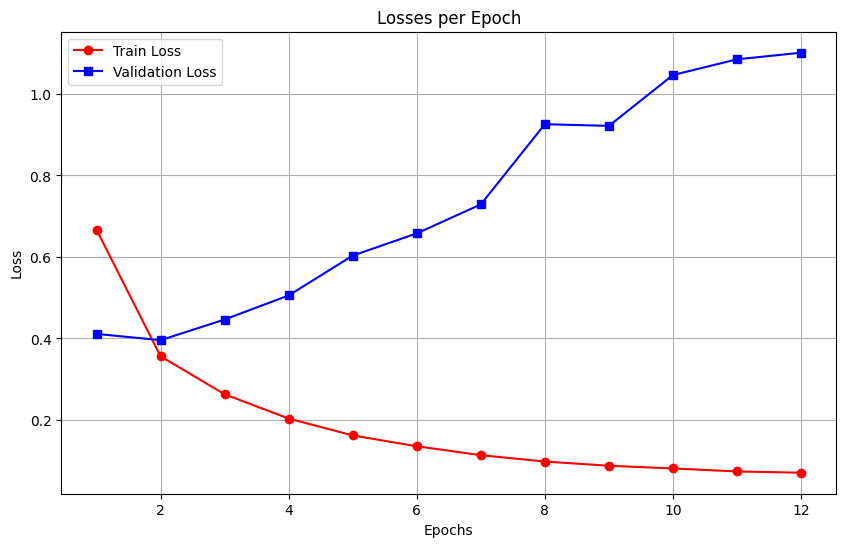

In [29]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss', color="r")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='s', label='Validation Loss', color="b")
plt.title('Losses per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

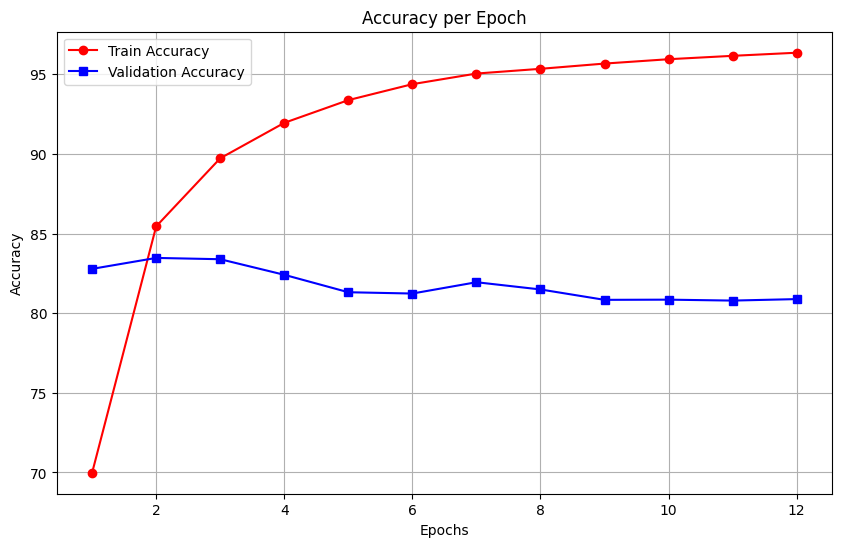

In [30]:
# Plotting Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label='Train Accuracy', color="r")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='s', label='Validation Accuracy', color="b")
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, val_loader, criterion, device):
    """
    Evaluates the LSTM model on a validation or test set.

    Parameters:
    - model: The trained LSTM sentiment classifier.
    - val_loader: DataLoader for validation or test set.
    - criterion: Loss function.
    - device: Device (CPU/GPU).

    Returns:
    - avg_loss: Average loss on the validation/test set.
    - accuracy: Accuracy score.
    - precision, recall, f1: Precision, Recall, and F1-score.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient calculation needed
        for batch in val_loader:
            inputs = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions
            y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true = labels.cpu().numpy()

            all_preds.extend(y_pred)
            all_labels.extend(y_true)

    # Compute average loss
    avg_loss = total_loss / len(val_loader)

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

In [32]:
test_loss, test_acc, test_prec, test_rec, test_f1, all_labels, all_preds = evaluate(model, test_loader, criterion, DEVICE)

Validation Loss: 1.0830
Accuracy: 0.8073
Precision: 0.8061
Recall: 0.8073
F1-score: 0.8063


dict_keys(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity'])


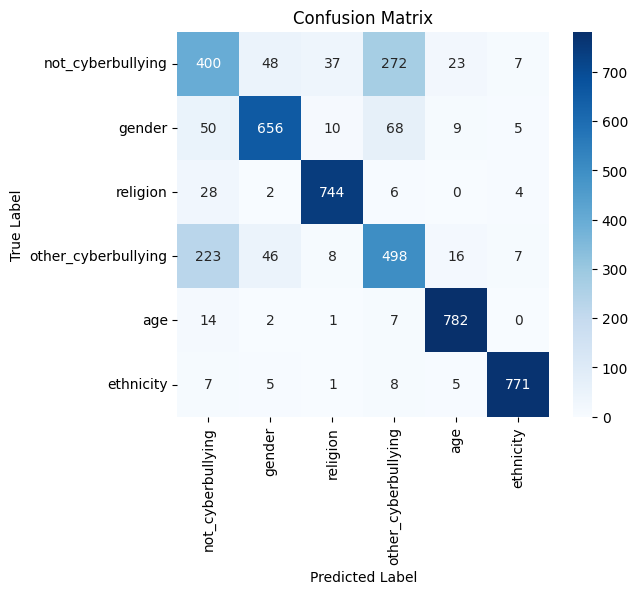

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

print(label_mapping.keys())
# Example usage:
plot_confusion_matrix(all_labels, all_preds, class_names=label_mapping.keys())

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer setup
max_words = 20000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)

def predict_label(sentence, model, tokenizer, label_mapping):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    input_tensor = torch.tensor(padded_sequence, dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_label = torch.argmax(output, dim=1).item()

    return {v: k for k, v in label_mapping.items()}[predicted_label]

# Example usage
random_sentence = "I love football!"
predicted_label = predict_label(random_sentence, model, tokenizer, label_mapping)
print(f"Predicted Label: {predicted_label}")

Predicted Label: other_cyberbullying
